In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()) * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy()) * num_docks
    y_gold = data["bikes"].to_numpy() * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
# Adding all files into one DataFrame
df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
#     show_nans(tmp)
#     replace_nan(tmp)
#     tmp = tmp.dropna(axis='rows')
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

columns = df.columns

nancount = pd.DataFrame(index = columns)
counts = []

for c in columns:

    counts.append(df[c].shape[0] - df[c].dropna().shape[0])
    
nancount["counts"] = counts
pd.set_option('display.max_rows', 23)
counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75,
 75,
 375,
 75,
 75,
 75,
 75,
 300,
 12825,
 12600,
 12825,
 12600,
 75]

In [4]:
def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    
    
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["day"]
    #del dataframe["hour"]
    del dataframe["weekhour"]
    
    #del dataframe["latitude"]
    #del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      "weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    #del dataframe["weekday"]
    default_columns.remove('weekday')
    
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    
#     columns_kept = ['isOff','full_profile_3h_diff_bikes', 'full_profile_bikes', 'bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes']
#     for c in list(dataframe.columns):
#         if c not in columns_kept:
#             del dataframe[c]
    
    return dataframe, num_docks

# Adding all files into one DataFrame
df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
    # show_nans(tmp)
    #replace_nan(tmp)
    tmp = tmp.dropna(axis='rows')
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

train, val = train_test_split(df, test_size=0.2)

train, train_docks = vectorise_dataframe(train)
val, val_docks = vectorise_dataframe(val)


# comment next line if not dropping NaNs



scaler = StandardScaler()
train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
val[val.columns[:-1]] = scaler.fit_transform(val[val.columns[:-1]])

print(df.columns)

Index(['isOff', 'isOff', 'weekday_Sunday', 'weekday_Monday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weekday_Thursday', 'weekday_Friday',
       'weekday_Saturday', 'numDocks', 'day', 'hour', 'isHoliday',
       'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades',
       'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago',
       'full_profile_3h_diff_bikes', 'full_profile_bikes',
       'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes'],
      dtype='object')
['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes']
Index(['isOff', 'isOff', 'weekday_Sunday', 'weekday_Monday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weekday_Thursday', 'weekday_Friday',
       'weekday_Saturday', 'numDocks', 'day', 'hour', 'isHoliday',
       'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades',
       'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_

(array([15077.,  9412.,  7218.,  5759.,  2925.,  1366.,   480.,   210.,
           50.,   103.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

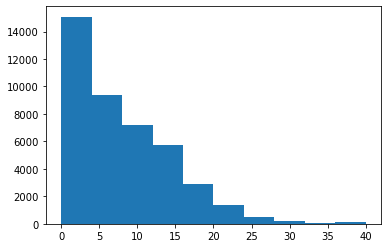

In [5]:
import matplotlib.pyplot as plt

plt.hist(df["bikes"])

In [6]:
# forest = RandomForestRegressor(n_estimators=100, n_jobs=6)
# print("initialised")
# forest.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# importances = forest.feature_importances_
# imp_indixes = np.argsort(importances)[::-1]
# feature_order = train.columns[:-1][imp_indixes]
# importances = importances[imp_indixes]

# imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])

# print(score_abs_error(forest, val, val_docks))

# print(imp_df)

In [7]:
# plot_features = feature_order[:5].to_list()
# plot_features.append("bikes")
# print(plot_features)

# g = sns.PairGrid(df[plot_features], diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)


In [8]:


# lowest_ranked_10 = feature_order[-5:]
# for feature in lowest_ranked_10:
#     del df[feature]
# print(imp_df)





In [9]:



# columns = list(df.columns[-6:])
# print(columns)
# for c in columns:
#     train[c] = train[c].to_numpy() / train["numDocks"].to_numpy()
#     val[c] = val[c].to_numpy() / val["numDocks"].to_numpy()


# train_docks = train["numDocks"]
# val_docks = train["numDocks"]
# del train["numDocks"]
# del val["numDocks"]

val

# See all Rows/Cols

#pd.set_option('display.max_rows', 23)

,isOff,isOff,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
31963,-0.303361,-0.303361,-1.057228,2.120792,0.277965,2.120792,0.277965,0.764706
36693,-0.303361,-0.303361,-0.821824,-0.001365,-0.898810,-0.001365,-0.898810,0.133333
543,-0.303361,-0.303361,-0.979792,-0.659013,-1.218660,-0.659013,-1.218660,0.000000
29086,-0.303361,-0.303361,-1.032448,-0.001365,0.264282,-0.001365,0.264282,0.066667
39104,-0.303361,-0.303361,-1.032448,0.499700,-0.898810,0.499700,-0.898810,0.133333
...,...,...,...,...,...,...,...,...
23935,-0.303361,-0.303361,0.968481,-0.001365,1.427374,-0.001365,1.427374,0.450000
33911,-0.303361,-0.303361,1.031668,-0.362132,1.473897,-0.362132,1.473897,0.640000
37330,-0.303361,-0.303361,-0.137296,-0.377164,0.903982,-0.377164,0.903982,0.350000
4279,-0.303361,-0.303361,0.652545,0.299274,0.496900,0.299274,0.496900,0.600000


In [10]:
df

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,...,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,206,39.472030,-0.370965,24,1.412730e+09,2014,10,8,3,Wednesday,...,21.5,59.0,1011.5,0.0,0.0,0.00,0.00,0.00,0.00,0.0
1,206,39.472030,-0.370965,24,1.412734e+09,2014,10,8,4,Wednesday,...,20.8,62.0,1011.1,0.0,0.0,0.00,0.00,0.00,0.00,0.0
2,206,39.472030,-0.370965,24,1.412737e+09,2014,10,8,5,Wednesday,...,19.8,67.0,1010.9,0.0,0.0,0.00,0.00,0.00,0.00,0.0
3,206,39.472030,-0.370965,24,1.412741e+09,2014,10,8,6,Wednesday,...,19.7,66.0,1010.8,0.0,0.0,1.00,1.00,1.00,1.00,1.0
4,206,39.472030,-0.370965,24,1.412744e+09,2014,10,8,7,Wednesday,...,19.6,67.0,1011.1,0.0,0.0,2.00,2.00,2.00,2.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42595,208,39.469056,-0.375728,34,1.414778e+09,2014,10,31,19,Friday,...,20.2,80.0,1023.5,0.0,12.0,0.25,10.00,0.25,10.00,6.0
42596,208,39.469056,-0.375728,34,1.414782e+09,2014,10,31,20,Friday,...,20.2,82.0,1023.9,0.0,9.0,-2.25,6.50,-2.25,6.50,7.0
42597,208,39.469056,-0.375728,34,1.414786e+09,2014,10,31,21,Friday,...,20.0,83.0,1024.0,0.0,6.0,-1.75,6.00,-1.75,6.00,6.0
42598,208,39.469056,-0.375728,34,1.414789e+09,2014,10,31,22,Friday,...,19.3,84.0,1024.4,0.0,6.0,-6.75,3.25,-6.75,3.25,5.0


# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [11]:
# forest_boost = GradientBoostingRegressor(n_estimators=n_est, loss='squared_error', learning_rate=0.2, max_depth=2, verbose=1)
#  forest_boost = SVR()
#searched_boost = RandomForestRegressor()#n_estimators = 50)#, verbose=1)
from time import time
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform



param_distributions = {"max_depth":  randint(2,6),#[2,3,4, 5, 6, None],
                       "min_samples_split": randint(2, 30),#np.around(np.linspace(2,30,5)).astype(np.int32),
                       "learning_rate": uniform(0.00001, 0.99999)#np.linspace(0.0001,1,20),
                       #"n_estimators": np.linspace(5, 5000, 5).astype(np.int32)
                      }


search = HalvingRandomSearchCV(searched_boost, param_distributions,
                               resource='n_estimators', max_resources = 5000, min_resources = 100,
                               factor = 2 ,cv = 3,    # n_candidates =  25
                               random_state=0, verbose=1, n_jobs=6).fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

print(search.cv_results_)
results_df = pd.DataFrame(search.cv_results_)

# n_meta_iterations = 25

# best_params = {"max_depth":7, "min_samples_split":15, "n_estimators":500}

# results = []

# for i in range(1, n_meta_iterations + 1):
#     print(f'\n---------------------------------\nIteration {i}\n')
#     fac = 0.75 / (i)
    
#     param_distributions = {}#"criterion": ["squared_error", "absolute_error", "poisson"]}
    
#     for param in list(best_params.keys()):
        
        
#         param_low = int(best_params[param]*(1-fac))
#         if param_low <= 1:
#             param_low  = param_low + 1
            
#         param_high = int(best_params[param]*(1+fac))
#         if param_high <= param_low:
#             param_high  = param_high + 1
        
#         print(f'low/high {param} limits {param_low, param_high}')
#         param_distributions[param] = randint(param_low, param_high)
        
#     #print(param_distributions)
    
# #     param_distributions = {"max_depth":  randint(2,5),   #, 5, 6, None],
# #                            "min_samples_split": randint(2,20),
# #                            #"learning_rate": np.linspace(0.0001,1,20),
# #                            #"n_estimators": np.linspace(5, 5000, 50).astype(np.int32)
# #                           }

#     search = RandomizedSearchCV(searched_boost, param_distributions, cv = 3, n_iter = 5,   # n_candidates =  25
#                                     verbose=1, n_jobs=5)
    
#     search.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())
    
#     results.append(search.cv_results_)
    


#     best_params = search.best_params_
    
#     searched_boost = RandomForestRegressor()#n_estimators = 50)#, verbose=1)

In [12]:




# searched_boost = GradientBoostingRegressor()

# param_distributions = {"max_depth":  randint(2, 10),   #, 5, 6, None],
#                        "min_samples_split": randint(2, 30),
#                        "learning_rate": uniform(),
#                        "n_estimators": randint(10, 5000)
#                       }

# search = RandomizedSearchCV(searched_boost, param_distributions, cv = 3, n_iter = 50,   # n_candidates =  25
#                                 verbose=2, n_jobs=5)

# search.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())


# print(search.best_params_)

In [14]:
# sns.pairplot(res, vars = feats, hue = "mean_test_score")

In [26]:
# from time import time
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# from sklearn.metrics import make_scorer

# print(SVR().get_params().keys())

# start = time()
# print("initialised")

# #scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# # svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

# parameters = [{'C': [1, 10, 100, 1000],
#                 'kernel': ['rbf'],#, 'poly', 'linear'], #'degree': [1,2,3,4,5],
#                'epsilon': 10**(-np.linspace(0, 5, 5)),#np.linspace(0.00001,0.1,10),
#                'gamma': [1e-5, 1e-4, 1e-3, 0.01, 0.1],
#                 'tol': [1e-4, 1e-3, 1e-2]#, 0.2, 0.5, 0.6, 0.9]
                                
#                }]

# print("Tuning hyper-parameters")
# search = GridSearchCV(SVR(), parameters, cv = 3, n_jobs = 6, verbose = 2)#, scoring = scorer)
# search.fit(train.iloc[:,:-1][::10], train["bikes"][::10])

# print(f'fitted in {time() - start}s')

# # #forest_boost = GradientBoostingRegressor(**search.best_params_, verbose = 1)
# # #forest_boost = GradientBoostingRegressor(**search.best_params_)
# # #forest_boost = RandomForestRegressor(n_estimators= 2500, max_depth= 3,  verbose = 1)
# # forest_boost = GradientBoostingRegressor(n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error")#
# # #SVR(kernel = 'poly', degree = 3, epsilon = 0.01)
# # forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())


dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])
initialised
Tuning hyper-parameters
Fitting 3 folds for each of 300 candidates, totalling 900 fits
fitted in 131.59279823303223s


In [54]:
print(search.best_params_)
#forest_boost = SVR(**search.best_params_).fit(train.iloc[:,:-1], train["bikes"])
forest_boost = SVR(C= 10, epsilon= 0.005623413251903491, gamma= 0.01, kernel= 'rbf', tol= 0.0001).fit(train.iloc[:,:-1], train["bikes"])
#forest_boost = SVR(kernel = 'rbf', gamma = 0.01, epsilon = 0.005, C = 100, tol = 1e-7).fit(train.iloc[:,:-1], train["bikes"])
print(score_abs_error(forest_boost, val, val_docks))
print(score_abs_error(forest_boost, val, val_docks, round_ = True))

{'C': 100, 'epsilon': 0.05623413251903491, 'gamma': 0.01, 'kernel': 'rbf', 'tol': 0.0001}


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


2.4691848568049757


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


2.449413145539906


In [52]:
import seaborn as sns
res = pd.DataFrame(search.cv_results_)



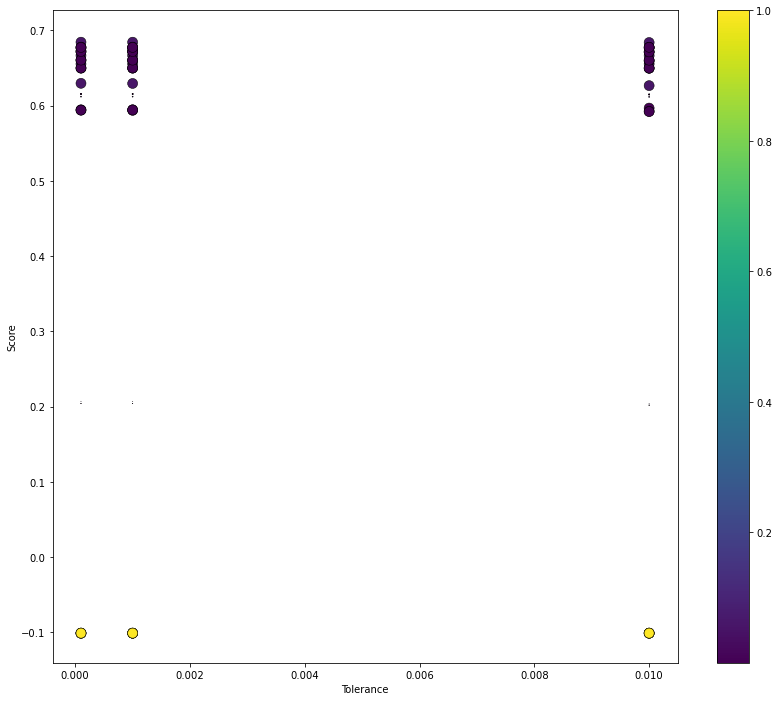

In [51]:
plt.figure(figsize=(14,12))
im = plt.scatter(res["param_tol"], res["mean_test_score"], c = res["param_epsilon"], s = 0.1*res["param_C"].to_numpy().astype(np.float32), linewidth = 0.5, edgecolor = '0')
plt.ylabel("Score")
plt.xlabel("Tolerance")
plt.colorbar(im)
plt.show()

## Score tracking

 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.31, rounding integers 2.29
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38
 
 - Random CV tuning on an svr gave: kernel = 'rbf', gamma = 0.001, epsilon = 0.15, C = 10000

In [20]:


results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
params = search.param_distributions
# results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
#learning_rates = params["learning_rate"]
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

fig, ax = plt.subplots(figsize=(16,12))
mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()


AttributeError: 'GridSearchCV' object has no attribute 'param_distributions'

In [18]:

# n_est = 10000

# import matplotlib.pyplot as plt
# test_score = np.zeros((n_est,), dtype=np.float64)

# y_test = val["bikes"]
# #y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

# for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
#     test_score[i] = forest_boost.loss_(y_test, y_pred)


# fig = plt.figure(figsize=(12
#                           , 12))
# plt.subplot(1, 1, 1)
# plt.title("Training and validation error")
# plt.plot(
#     np.arange(n_est) + 1,
#     forest_boost.train_score_,
#     "b-",
#     label="Training Set",
# )
# plt.plot(
#     np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
# )
# plt.legend(loc="upper right")
# plt.xlabel("Boosting Iterations")
# plt.ylabel("Absolute error")
# plt.yscale('log')
# fig.tight_layout()
# plt.show()

In [19]:
plt.figure(figsize=(8,8))
plt.hist(y_test*val_docks - forest_boost.predict(val.iloc[:,:-1])*val_docks, bins = 30)
plt.show()

NameError: name 'y_test' is not defined

<Figure size 576x576 with 0 Axes>

In [ ]:
test = pd.read_csv('test.csv')

ids = test["Id"]

# del test["Id"]
# del test["month"]
# del test["year"]

# convert_weekdays(test)
# # test[test.columns] = scaler.fit_transform(test[test.columns])

# for feature in lowest_ranked_10:
#     del test[feature]
    
# print(test.columns)  
# print(train.columns)

test, test_docks = generate_dataframe(test)

#y_pred = forest_boost.predict(test)
y_pred = reasonable_predictions(forest_boost, test) * test_docks

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("trial.csv")